# Distribution fitting with pytorch 

## Overview 
This is a POC of using pytorch to do distribution fitting. This might be useful because it might give us more control over things like parameter initialization, learning rate, and optimization configuration. Also, it makes it easy to track how estimates change during the optimization process. This can help us identify cases where we're getting stuck in local minima. 

- Use the likelihood function of weibull 2p as the loss function 
- The "model" is really just the shape and scale params. During training, we run N iterations. In each iteration, we use the current estimated params to evaluate the loss, calculate gradient, and take an optimization step. 
- After some experimentation, the following config seems to work well: 
  - Initialize weights/params with `weights = torch.distributions.Uniform(0, 4).sample((2,))`
  - Use optimizer `torch.optim.Adam(m.parameters(), lr=.01, amsgrad=True)`
  - Use n=2000 iterations in training loop (similar to epochs in more standard ML problems)


Other things to try: 
- Fit mixtures of Weibulls instead of single weibulls. See function `weibull_mixture_nll` below. We would also have to change the `Model` class to have six weights: `p1, p2, shape1, shape2, scale1, scale2`
- LBFGS instead of Adam
- Set up tracking of validation loss + early stopping
- Check why Adam can't deal estimate large scale values. Confirm that LBFGS can. 


## References: 
- [How to use Pytorch as a general optimizer](https://towardsdatascience.com/how-to-use-pytorch-as-a-general-optimizer-a91cbf72a7fb)
- [pytorch Adam vs LBFGS](https://soham.dev/posts/linear-regression-pytorch/)

In [1]:
import numpy as np
from scipy.stats import weibull_min, beta, gaussian_kde
import torch
import torch.nn as nn
from torch.functional import F
from torch.autograd import Variable
import plotly.graph_objects as go
import matplotlib.pyplot as plt 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data setup 

In [2]:
np.random.seed(2023)

n = 100
shape = 0.8
scale = 400

/opt/conda/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:2108: RuntimeWarning: divide by zero encountered in power
  return c*pow(x, c-1)*np.exp(-pow(x, c))


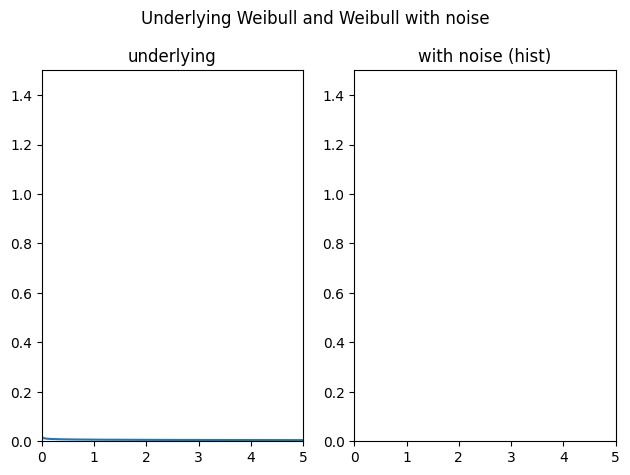

In [3]:
#generate points for weibull, set location parameter to 0 - this is 2-parameter because loc is 0
weibull_data = weibull_min.rvs(c=shape, scale=scale, loc=0, size=n)

#add noise, mean = 0, sd = 0.1 for the same sample size
noise = np.random.normal(0, 0.1, n)  
weibull_data = weibull_data + noise
#all positive data
weibull_data = np.abs(weibull_data) + 1e-4

#generate the x values to be used for generating the pdf
curve_x = np.linspace(0, 5, 1000)
#generate the pdf with the same parameters that were used for generating the data
weibull_pdf = weibull_min.pdf(curve_x, shape, scale=scale)

title='Underlying Weibull and Weibull with noise'
subs = ['underlying', 'with noise (hist)']
fig, ax = plt.subplots(1, 2)
ax[0].plot(curve_x, weibull_pdf)
ax[1].hist(weibull_data, bins=10, density=True)

for idx in range(2): 
    ax[idx].set_xlim(0, 5)
    ax[idx].set_ylim(0, 1.5)
    ax[idx].set_title(subs[idx])
plt.suptitle(title)
fig.tight_layout()
fig.show()

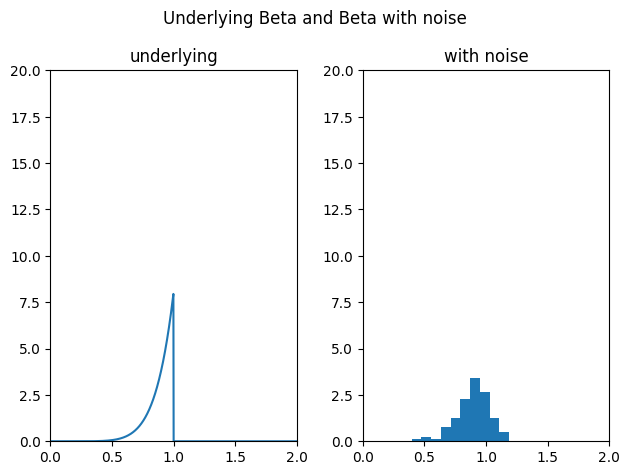

In [4]:
#generate non-weibull data, following beta distribution
beta_data = beta.rvs(a=8, b=1, size=n)
#add noise
beta_data = beta_data + noise
#all positive data
beta_data = np.abs(beta_data)

#generate the pdf with the same parameters that were used for generating the data
curve_x = np.linspace(0, 2, 1000)
beta_pdf = beta.pdf(curve_x, a=8, b=1)

title='Underlying Beta and Beta with noise'
subs = ['underlying', 'with noise']
fig, ax = plt.subplots(1, 2)
ax[0].plot(curve_x, beta_pdf)
ax[1].hist(beta_data, density=True)

for idx in range(2): 
    ax[idx].set_xlim(0, 2.0)
    ax[idx].set_ylim(0, 20.0)
    ax[idx].set_title(subs[idx])
plt.suptitle(title)
fig.tight_layout()
fig.show()

****
# Utility functions 

In [5]:
def plot_weibull_distributions(params1, params2):
    shape1, scale1 = params1
    shape2, scale2 = params2
    
    # Create Weibull distribution objects
    weibull_dist1 = weibull_min(c=shape1, scale=scale1)
    weibull_dist2 = weibull_min(c=shape2, scale=scale2)
    
    # Generate x values for the plot
    x = np.linspace(0, max(scale1, scale2) * 2, 1000)
    
    # Calculate probability density function values for each distribution
    pdf1 = weibull_dist1.pdf(x)
    pdf2 = weibull_dist2.pdf(x)
    
    # Plot the distributions
    plt.plot(x, pdf1, label=f'Weibull ({shape1:.2f}, {scale1:.2f})')
    plt.plot(x, pdf2, label=f'Weibull ({shape2:.2f}, {scale2:.2f})')
    plt.xlabel('x')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.title('Weibull Distributions')
    plt.show()

****
# Model setup 

In [6]:
class Model(nn.Module):
    """Custom Pytorch model for gradient optimization.
    """
    def __init__(self):        
        super().__init__()
        # initialize weights with random numbers
        weights = torch.distributions.Uniform(0, 4).sample((2,))
        # make weights torch parameters
        self.weights = nn.Parameter(weights)        
        
    def forward(self, X):
        """Implement function to be optimised. In this case, a 2-parameter Weibull
        distribution (f(x) = (k / lambda) * (x / lambda)^(k - 1) * exp(-(x / lambda)^k)),
        """
        lambda_, k = self.weights
        weibull_pdf = (k / lambda_) * (X / lambda_)**(k - 1) * torch.exp(-((X / lambda_)**k))
        
        return weibull_pdf


In [7]:
def train_loop(model, optimizer, data_tensor, n=1000): 
    losses = []
    print('scale, shape, loss \n')
    for i in range(n):
        preds = model(data_tensor)
        # loss = F.mse_loss(preds, data_tensor).sqrt()  # todo: use neg log likelihood? 
        lambda_, k = model.weights
        loss = weibull_nll(data_tensor, lambda_, k)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss) 
        if i % 100 == 0: 
            print(f'iter {i}: {lambda_}, {k}, {loss}')
        
    return losses

In [8]:
def weibull_nll(data, lambda_, k): 
    log_likelihood = torch.sum(torch.log(k / lambda_) + (k - 1) * torch.log(data / lambda_) - (data / lambda_) ** k)
    nll = -log_likelihood
    return nll

In [9]:
def weibull_mixture_nll(data, alphas, betas, pis):
    # todo: verify that this is correct 
    data = data.unsqueeze(1).expand_as(alphas)
    likelihood = pis * torch.exp((torch.log(data) - torch.log(alphas)) * betas - (data / alphas) ** betas)
    log_likelihood = torch.log(likelihood.sum(dim=1)).sum()
    nll = -log_likelihood
    return nll

****
# Using Adam optimizer on Weibull data 

scale, shape, loss 

iter 0: 0.2100219875574112, 1.8465938568115234, 284709682.1732108
iter 100: 0.44440850615501404, 1.5452754497528076, 5609831.518081147
iter 200: 0.4798738658428192, 1.4665313959121704, 2710385.3075904083
iter 300: 0.5016447901725769, 1.413283109664917, 1692378.3647314017
iter 400: 0.517086386680603, 1.3730576038360596, 1196704.1718023326
iter 500: 0.5289177894592285, 1.340755820274353, 910613.1644526965
iter 600: 0.5384312868118286, 1.3137931823730469, 727238.3686755202
iter 700: 0.5463376045227051, 1.29067862033844, 601030.7164560333
iter 800: 0.5530692934989929, 1.2704716920852661, 509569.04061338847
iter 900: 0.5589065551757812, 1.252538800239563, 440639.22812942584
iter 1000: 0.5640424489974976, 1.2364351749420166, 387072.2448250819
iter 1100: 0.5686143636703491, 1.2218340635299683, 344399.42904281424
iter 1200: 0.5727238059043884, 1.2084894180297852, 309705.6488255713
iter 1300: 0.5764479637145996, 1.196210265159607, 281011.68137503596
iter 1400: 0.57984679937

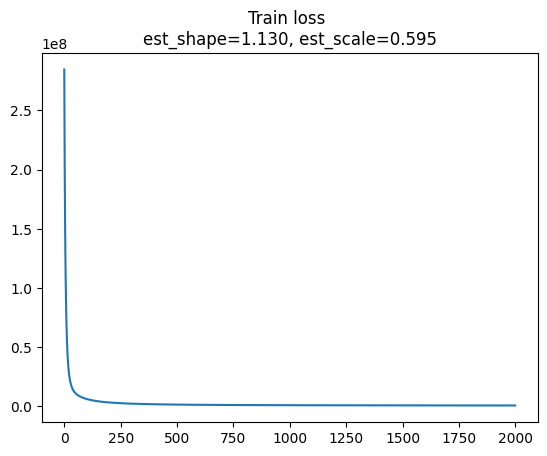

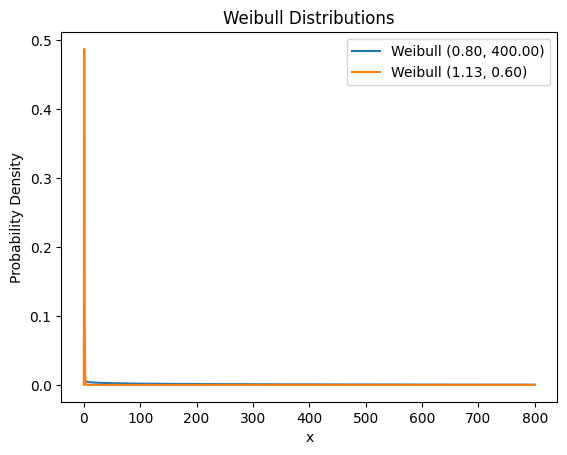

Actual shape=0.8


In [10]:
# min-max scale to speed up convergence. This means we won't get correctly estimated scale param, 
# but shape param will remain same. 
# weibull_data_scaled = [(x - weibull_data.min()) / (weibull_data.max() - weibull_data.min()) for x in weibull_data]
weibull_tensor = torch.tensor(weibull_data, dtype=float).reshape(-1,1)

m = Model()
opt = torch.optim.Adam(m.parameters(), lr=.01, amsgrad=True)
# opt = torch.optim.SGD(m.parameters(), lr=.1)

losses = train_loop(m, opt, data_tensor=weibull_tensor, n=2000)
losses = [loss.detach().numpy().tolist() for loss in losses]
fitted_params = m.weights

estimated_scale = fitted_params.detach().numpy()[0]
estimated_shape = fitted_params.detach().numpy()[1]
print(f'\nFitted params: shape={estimated_shape:.3f}, scale={estimated_scale:.3f}')
print(f'\nActual params: shape={shape}, scale={scale}')
print(f'\nabs(actual minus predicted) for shape={np.abs(shape-fitted_params[0].detach().numpy()):.2f}')
print(f'\nabs(actual minus predicted) for scale={np.abs(scale-fitted_params[1].detach().numpy()):.2f}')

plt.plot(losses)
plt.title(f'Train loss \nest_shape={estimated_shape:.3f}, est_scale={estimated_scale:.3f}')
# plt.ylim(bottom=0)
plt.show()

plot_weibull_distributions((shape, scale), (estimated_shape, estimated_scale))
print(f'Actual shape={shape}')

# Using Adam optimizer on Beta data 

scale, shape, loss 

iter 0: 2.374281883239746, 3.8711609840393066, 240.58267420083408
iter 100: 1.3628934621810913, 3.1311838626861572, 40.14826058057291
iter 200: 0.9206339716911316, 3.57132625579834, -24.886034585675198
iter 300: 0.923387885093689, 4.166426181793213, -35.63517999958606
iter 400: 0.9276320338249207, 4.691675186157227, -42.96365320985251
iter 500: 0.9311653971672058, 5.150320053100586, -48.013608087586135
iter 600: 0.93411785364151, 5.546950817108154, -51.511821450037914
iter 700: 0.9365913271903992, 5.888204097747803, -53.94964890166783
iter 800: 0.9386680126190186, 6.180866241455078, -55.65698277032676
iter 900: 0.9404147267341614, 6.431266784667969, -56.85722615597041
iter 1000: 0.9418855309486389, 6.64509916305542, -57.70322474502095
iter 1100: 0.9431250691413879, 6.827392578125, -58.300545490666735
iter 1200: 0.9441701769828796, 6.982558250427246, -58.72270325654289
iter 1300: 0.945051372051239, 7.114435195922852, -59.02118346934977
iter 1400: 0.9457943439483643,

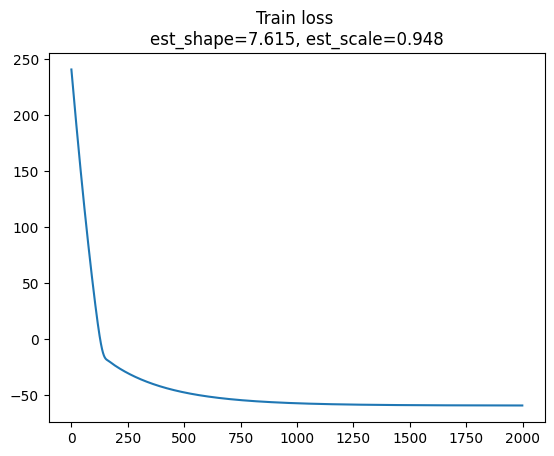

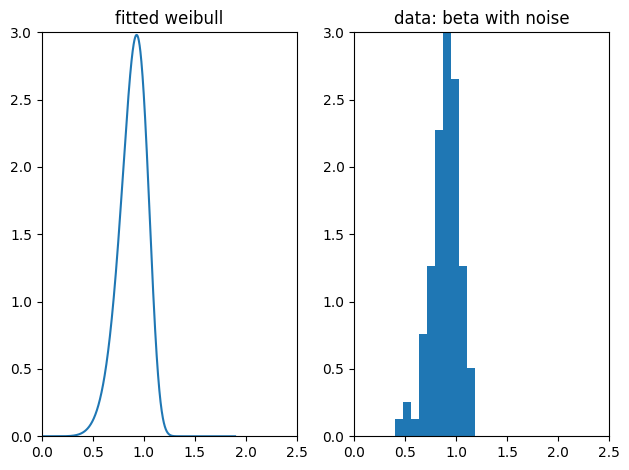

In [11]:
beta_tensor = torch.tensor(beta_data, dtype=float).reshape(-1,1)

m = Model()
opt = torch.optim.Adam(m.parameters(), lr=.01, amsgrad=True)
# opt = torch.optim.SGD(m.parameters(), lr=.1)

losses = train_loop(m, opt, data_tensor=beta_tensor, n=2000)
losses = [loss.detach().numpy().tolist() for loss in losses]
fitted_params = m.weights

estimated_scale = fitted_params.detach().numpy()[0]
estimated_shape = fitted_params.detach().numpy()[1]
print(f'\nFitted params: shape={estimated_shape:.3f}, scale={estimated_scale:.3f}')
# print(f'\nActual params: shape={shape}, scale={scale}')
# print(f'\nabs(actual minus predicted) for shape={np.abs(shape-fitted_params[0].detach().numpy()):.2f}')
# print(f'\nabs(actual minus predicted) for scale={np.abs(scale-fitted_params[1].detach().numpy()):.2f}')

plt.plot(losses)
plt.title(f'Train loss \nest_shape={estimated_shape:.3f}, est_scale={estimated_scale:.3f}')
# plt.ylim(bottom=0)
plt.show()


txt = 'Fitted weibull vs beta_data_with_noise'
subs = ['fitted weibull', 'data: beta with noise']
fig, ax = plt.subplots(1, 2)
weibull_dist = weibull_min(c=estimated_shape, scale=estimated_scale)
x = np.linspace(0, estimated_scale*2, 1000)
weibull_pdf = weibull_dist.pdf(x)
ax[0].plot(x, weibull_pdf, label='fitted weibull')
ax[1].hist(beta_data, density=True)

for idx in range(2): 
    ax[idx].set_title(subs[idx])
    ax[idx].set_xlim(0, 2.5)
    ax[idx].set_ylim(0, 3.0)

fig.tight_layout()
fig.show()


****
# Using LBFGS optimizer on Weibull data 

scale, shape, loss 

iter 0: 3.373870849609375, 1.8047559261322021, 1102930.726677373
iter 0: 3.382157564163208, 1.7130424976348877, 639671.2885901586
iter 0: 3.3831608295440674, 1.7006648778915405, 594614.5291407179
iter 0: 3.38434100151062, 1.6846354007720947, 541061.6319835915
iter 0: 3.3853917121887207, 1.6687480211257935, 492856.10056244396
iter 0: 3.386326313018799, 1.6528152227401733, 448927.6961339273
iter 0: 3.387143850326538, 1.6368461847305298, 408921.026916736
iter 0: 3.3878438472747803, 1.6208404302597046, 372484.8312669288
iter 0: 3.3884263038635254, 1.6047979593276978, 339300.34656149056
iter 0: 3.388890504837036, 1.5887184143066406, 309076.7302735945
iter 0: 3.3892362117767334, 1.5726017951965332, 281549.76661102416
iter 0: 3.38946270942688, 1.5564478635787964, 256478.5096701101
iter 0: 3.3895697593688965, 1.5402568578720093, 233644.17576505127
iter 0: 3.389556884765625, 1.5240281820297241, 212846.4078452473
iter 0: 3.3894236087799072, 1.5077621936798096, 193903.9783236

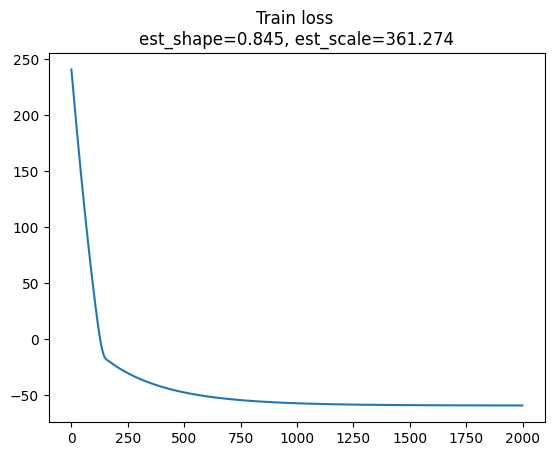

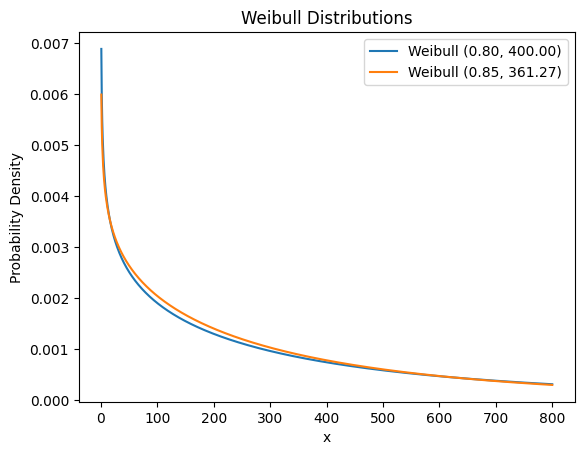

Actual shape=0.8


In [12]:
model2 = Model()

# Create the optimizer
optimizer = torch.optim.LBFGS(model2.parameters(), lr=0.1)

# Training loop
print('scale, shape, loss \n')
num_iterations = 2000
for i in range(num_iterations):
    def closure():
        optimizer.zero_grad()
        weibull_pdf = model2(weibull_tensor)
        lambda_, k = model2.weights
        loss = weibull_nll(weibull_tensor, lambda_, k)
        loss.backward()
        if i % 100 == 0 or i == num_iterations-1: 
            print(f'iter {i}: {lambda_}, {k}, {loss}')
        return loss

    optimizer.step(closure)

fitted_params = model2.weights
estimated_scale = fitted_params.detach().numpy()[0]
estimated_shape = fitted_params.detach().numpy()[1]
print(f'\nFitted params: shape={estimated_shape:.3f}, scale={estimated_scale:.3f}')
print(f'\nActual params: shape={shape}, scale={scale}')
print(f'\nabs(actual minus predicted) for shape={np.abs(shape-fitted_params[0].detach().numpy()):.2f}')
print(f'\nabs(actual minus predicted) for scale={np.abs(scale-fitted_params[1].detach().numpy()):.2f}')

plt.plot(losses)
plt.title(f'Train loss \nest_shape={estimated_shape:.3f}, est_scale={estimated_scale:.3f}')
# plt.ylim(bottom=0)
plt.show()

plot_weibull_distributions((shape, scale), (estimated_shape, estimated_scale))
print(f'Actual shape={shape}')

****
# Random stuff 

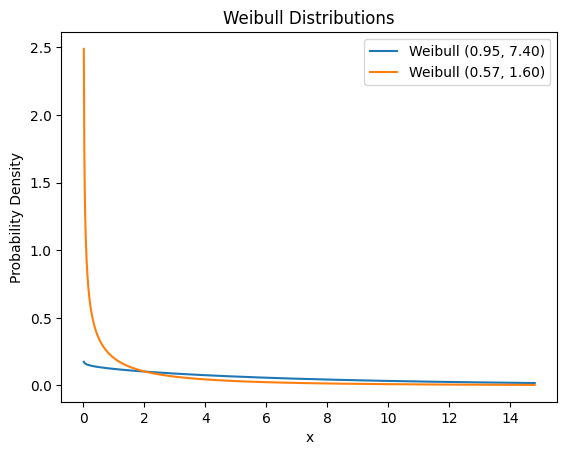

In [13]:
plot_weibull_distributions((.95, 7.4), (.57, 1.6))